In [1]:
from pykrx import stock
import pandas as pd
from datetime import datetime
import pickle
import warnings
import FinanceDataReader as fdr
from sklearn.linear_model import LinearRegression
# import statsmodels.api as sm
warnings.filterwarnings('ignore')

# 빈 테이블 만들기

In [2]:
listColumns = ['stock_code','period','category1','category2','시가총액','상장주식수','총자산','현금','부채','지배자산',
              '매출액Y','매출원가Y','매출총이익Y','판관비Y','영업이익Y','당기순이익Y','지배순이익Y','영업활동현금흐름Y',
              '매출액Q','매출원가Q','매출총이익Q','판관비Q','영업이익Q','당기순이익Q','지배순이익Q','영업활동현금흐름Q',
              '매출액','매출원가','매출총이익','판관비','영업이익','당기순이익','지배순이익','영업활동현금흐름']
def makeDataframeBlank(dateBase : datetime):
    # kospi_list = stock.get_market_ticker_list(date, market='KOSPI')
    # kosdaq_list = stock.get_market_ticker_list(date, market='KOSDAQ')
    market_cap_kospi = stock.get_market_cap_by_ticker(date=dateBase, market='KOSPI')
    market_cap_kosdaq = stock.get_market_cap_by_ticker(date=dateBase, market='KOSDAQ')
    dfBlank = pd.DataFrame(columns = listColumns)
    dfBlank['stock_code']= list(market_cap_kospi.index) + list(market_cap_kosdaq.index)
    dfBlank['period'] = definePeriod(dateBase = dateBase)
    dfBlank['category1'] = ['kospi']*len(market_cap_kospi) + ['kosdaq']*len(market_cap_kosdaq)
    dfBlank['시가총액'] = list(market_cap_kospi['시가총액']) + list(market_cap_kosdaq['시가총액'])
    dfBlank['거래량'] = list(market_cap_kospi['거래량']) + list(market_cap_kosdaq['거래량'])
    dfBlank['거래대금'] = list(market_cap_kospi['거래대금']) + list(market_cap_kosdaq['거래대금'])
    dfBlank['상장주식수'] = list(market_cap_kospi['상장주식수']) + list(market_cap_kosdaq['상장주식수'])
    return dfBlank

In [3]:
def definePeriod(dateBase : datetime):
    if dateBase.month == 4:
        period = str(dateBase.year-1) + '12'
    elif dateBase.month == 5:
        period = str(dateBase.year) + '03'
    elif dateBase.month == 8:
        period = str(dateBase.year) + '06'
    elif dateBase.month == 11:
        period = str(dateBase.year) + '09'
    else:
        print("check dateBase!!!")
    return period

In [4]:
start = datetime(2020,9,1)
end = datetime(2022,5,30)
listPeriod = []
for year in range(start.year, end.year+1):
    for date in [datetime(year,4,1), datetime(year,5,15), datetime(year,8,15), datetime(year,11,15)]:
        if (date >= start)&(date <= end):
            listPeriod.append(date)
print(listPeriod)
dfBlankAll = pd.DataFrame()
for dateBase in listPeriod:
    dfBlankTemp = makeDataframeBlank(dateBase=dateBase)
    dfBlankAll = pd.concat([dfBlankAll,dfBlankTemp],axis=0)
dfBlankAll.reset_index(drop=True,inplace=True)

[datetime.datetime(2020, 11, 15, 0, 0), datetime.datetime(2021, 4, 1, 0, 0), datetime.datetime(2021, 5, 15, 0, 0), datetime.datetime(2021, 8, 15, 0, 0), datetime.datetime(2021, 11, 15, 0, 0), datetime.datetime(2022, 4, 1, 0, 0), datetime.datetime(2022, 5, 15, 0, 0)]


# DartAPI 자료 활용하여 값 넣기

## 출처 값을 그대로 넣기

In [5]:
value_dict = {'총자산':'ifrs-full_Assets', '현금':'ifrs-full_CashAndCashEquivalents',
              '부채':'ifrs-full_Liabilities','지배자산':'ifrs-full_EquityAttributableToOwnersOfParent',
             '매출액':'ifrs-full_Revenue', '매출원가':'ifrs-full_CostOfSales', 
              '매출총이익':'ifrs-full_GrossProfit', '판관비':'dart_TotalSellingGeneralAdministrativeExpenses',
              '영업이익':'dart_OperatingIncomeLoss',
#               '계속영업이익':'ifrs-full_ProfitLossFromContinuingOperations',
              '당기순이익':'ifrs-full_ProfitLoss', '지배순이익':'ifrs-full_ProfitLossAttributableToOwnersOfParent',
             '영업활동현금흐름':'ifrs-full_CashFlowsFromUsedInOperatingActivities'}

In [6]:
listCategory = ['총자산','현금','부채','지배자산','매출액','매출원가','매출총이익','판관비','영업이익','당기순이익','지배순이익','영업활동현금흐름']
# listPeriodStr = ['202109','202106','202103','202012','202009','202006','202003','201912', '201909']
listPeriodStr = list(set(dfBlankAll.period))
listPeriodStr.sort(reverse=True)

In [7]:
def makeSeriesValueByCategory(category : str):
    cases_temp = dfFinancePeriod[dfFinancePeriod.account_id == value_dict[category]][['stock_code','period','thstrm_amount']]
    cases_temp.drop_duplicates(['stock_code','period'],keep='first',inplace=True)
    dfBlankAll_temp = dfBlankAll[['stock_code','period']]
    seriesValue = pd.merge(dfBlankAll_temp,cases_temp,how='left',on=['stock_code','period'])['thstrm_amount']
    return seriesValue

In [8]:
for period in listPeriodStr:
    with open(f'Raw_Finance/dartAPI/{period}.pickle','rb') as handle:
        dfFinancePeriod = pickle.load(handle)
    dfFinancePeriod['period'] = period
    for nameCategory in listCategory:
    #     dfBlankAll.loc[dfBlankAll.period==period,nameCategory]=makeSeriesValueByCategory(nameCategory)
        dfBlankAll[nameCategory].fillna(makeSeriesValueByCategory(nameCategory), inplace=True)

In [9]:
for category in listCategory:
    dfBlankAll[category] = pd.to_numeric(dfBlankAll[category])

In [10]:
dfBlankAll[dfBlankAll.period=='202203'].isnull().sum()

stock_code       0
period           0
category1        0
category2     2498
시가총액             0
상장주식수            0
총자산            320
현금             320
부채             320
지배자산           791
매출액Y          2498
매출원가Y         2498
매출총이익Y        2498
판관비Y          2498
영업이익Y         2498
당기순이익Y        2498
지배순이익Y        2498
영업활동현금흐름Y     2498
매출액Q          2498
매출원가Q         2498
매출총이익Q        2498
판관비Q          2498
영업이익Q         2498
당기순이익Q        2498
지배순이익Q        2498
영업활동현금흐름Q     2498
매출액            371
매출원가           456
매출총이익          467
판관비            465
영업이익           325
당기순이익          327
지배순이익         1029
영업활동현금흐름       338
거래량              0
거래대금             0
dtype: int64

## 출처값으로 Q, Y 값 넣기

In [11]:
for i in range(len(listPeriodStr)-4):
    for category in listCategory[4:]:
        dfPeriod = dfBlankAll[dfBlankAll.period == listPeriodStr[i]][['stock_code','period',category]]
        if listPeriodStr[i][-2:] != '12':
            dfPeriodMinus4Q = dfBlankAll[dfBlankAll.period == listPeriodStr[i+4]][['stock_code',category]].rename(columns={category:category+'4Q'})
            dfPeriodLastYear = dfBlankAll[dfBlankAll.period == (str(int(listPeriodStr[i][:4])-1)+'12')][['stock_code',category]].rename(columns={category:category+'LY'})
            dfPeriod = pd.merge(dfPeriod,dfPeriodLastYear,how='left',on=['stock_code'])
            dfPeriod = pd.merge(dfPeriod,dfPeriodMinus4Q,how='left',on=['stock_code'])
            dfPeriod[f'{category}Y'] = dfPeriod[category] + dfPeriod[f'{category}LY'] - dfPeriod[f'{category}4Q']
        else:
            dfPeriod[f'{category}Y'] = dfPeriod[category]
        dfPeriodMinus1Q = dfBlankAll[dfBlankAll.period == listPeriodStr[i+1]][['stock_code',category]].rename(columns={category:category+'1Q'})
        dfPeriod = pd.merge(dfPeriod,dfPeriodMinus1Q,how='left',on=['stock_code'])
        dfPeriod[f'{category}Q'] = dfPeriod[category] - dfPeriod[f'{category}1Q']
        
        dfBlankAll_temp = dfBlankAll[['stock_code','period']]
        dfPeriod_temp = dfPeriod[['stock_code','period',f'{category}Y']]
        seriesValue = pd.merge(dfBlankAll_temp,dfPeriod_temp,how='left',on=['stock_code','period'])[f'{category}Y']
        dfBlankAll[f'{category}Y'].fillna(seriesValue, inplace=True)

        dfPeriod_temp = dfPeriod[['stock_code','period',f'{category}Q']]
        seriesValue = pd.merge(dfBlankAll_temp,dfPeriod_temp,how='left',on=['stock_code','period'])[f'{category}Q']
        dfBlankAll[f'{category}Q'].fillna(seriesValue, inplace=True)

In [12]:
dfAll = dfBlankAll[['stock_code','period','총자산','현금','부채','지배자산','매출액Y','매출원가Y',
                    '매출총이익Y','판관비Y','영업이익Y','당기순이익Y','지배순이익Y','영업활동현금흐름Y']]
dfAll = dfAll.rename(columns = {'매출액Y':'매출액','매출원가Y':'매출원가','매출총이익Y':'매출총이익','판관비Y':'판관비',
                      '영업이익Y':'영업이익','당기순이익Y':'당기순이익','지배순이익Y':'지배순이익','영업활동현금흐름Y':'영업활동현금흐름'})

In [13]:
dfAll = dfBlankAll[['stock_code','period','총자산','현금','부채','지배자산','매출액','매출원가','매출총이익','판관비','영업이익','당기순이익','지배순이익','영업활동현금흐름']]

In [14]:
dfAll['period'] = pd.to_numeric(dfAll['period'])

In [15]:
with open('Raw_Finance/finance_dartapi.pickle','wb') as handle:
    pickle.dump(dfAll, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
with open('Raw_Finance/finance_dartapi.pickle','rb') as handle:
    cases = pickle.load(handle)

In [18]:
cases.isnull().sum()

stock_code       0
period           0
총자산           2152
현금            2151
부채            2142
지배자산          5404
매출액           2446
매출원가          3027
매출총이익         3131
판관비           3123
영업이익          2174
당기순이익         2198
지배순이익         6901
영업활동현금흐름      2259
dtype: int64

## 통계분석

In [3]:
with open('Raw_Finance/finance_dartapi.pickle','rb') as handle:
    cases = pickle.load(handle)

In [151]:
def defineThisDate(period : str):
    if period[-2:] == '03':
        dateStart = period[:4] + '0401'
        dateEnd = period[:4] + '0515'
    elif period[-2:] == '06':
        dateStart = period[:4]+'0515'
        dateEnd = period[:4]+'0815'
    elif period[-2:] == '09':
        dateStart = period[:4] + '0815'
        dateEnd = period[:4] + '1115'
    elif period[-2:] == '12':
        dateStart = period[:4] + '1115'
        dateEnd = str(int(period[:4])+1) + '0401' 
    else:
        print('check period')
    return dateStart,dateEnd

In [152]:
def defineNextDate(period : str):
    if period[-2:] == '03':
        dateStart = period[:4]+'0515'
        dateEnd = period[:4]+'0815'
    elif period[-2:] == '06':
        dateStart = period[:4] + '0815'
        dateEnd = period[:4] + '1115'
    elif period[-2:] == '09':
        dateStart = period[:4] + '1115'
        dateEnd = str(int(period[:4])+1) + '0401' 
    elif period[-2:] == '12':
        dateStart = str(int(period[:4])+1) + '0401'
        dateEnd = str(int(period[:4])+1) + '0515'
    else:
        print('check period')
    return dateStart,dateEnd

In [9]:
def calculateRegressedReturn(listYield : pd.Series):
    # 1년간의 cumprod() 값을 활용하여, x축은 index, y축은 수익률
    lr = LinearRegression()
    axisX = np.arange(len(listYield))/252
    axisX = axisX.reshape(-1,1)
    axisY = np.array(listYield.cumprod())
    axisY = axisY.reshape(-1,1)
    lr.fit(axisX, axisY)
    rar = lr.coef_ # Regressed Annual Return
    # rSquare = lr.score(axisX,axisY)
    return rar[0][0]

In [72]:
dfBlankAll['BPR'] = dfBlankAll['총자산'] / dfBlankAll['시가총액']
dfBlankAll['EPR'] = dfBlankAll['당기순이익Y'] / dfBlankAll['시가총액']
dfBlankAll['SPR'] = dfBlankAll['매출액Y'] / dfBlankAll['시가총액']
dfBlankAll['CPR'] = dfBlankAll['영업활동현금흐름Y'] / dfBlankAll['시가총액']
dfBlankAll['SPPR'] = dfBlankAll['매출총이익Y'] / dfBlankAll['시가총액']
dfBlankAll['시가총액']
dfBlankAll_modi = dfBlankAll.dropna(subset=['BPR','EPR','SPR','CPR','SPPR','시가총액'],how='any')


In [158]:
dfBlankAll_modi_lastperiod = dfBlankAll_modi[dfBlankAll_modi.period == '202009']
dfBlankAll_modi_thisperiod = dfBlankAll_modi[dfBlankAll_modi.period == '202012']

In [161]:
listNextRar = []
for i in range(len(dfBlankAll_modi_lastperiod)):
    stock_code = dfBlankAll_modi_lastperiod.iat[i,0]
    dateStart, dateEnd = defineNextDate(str(dfBlankAll_modi_lastperiod.iat[i,1]))
    dfOHLCV = fdr.DataReader(symbol = stock_code ,start=dateStart, end=dateEnd)
    nextRar = calculateRegressedReturn(dfOHLCV.Change+1)
    listNextRar.append(nextRar)
dfBlankAll_modi_lastperiod['RAR'] = listNextRar

In [163]:
np.nan

nan

In [164]:
listNextRar = []
for i in range(len(dfBlankAll_modi_thisperiod)):
    stock_code = dfBlankAll_modi_thisperiod.iat[i,0]
    dateStart, dateEnd = defineNextDate(str(dfBlankAll_modi_thisperiod.iat[i,1]))
    dfOHLCV = fdr.DataReader(symbol = stock_code ,start=dateStart, end=dateEnd)
    try:
        nextRar = calculateRegressedReturn(dfOHLCV.Change+1)
    except:
        nextRar = 0
        print(stock_code)
    listNextRar.append(nextRar)
dfBlankAll_modi_thisperiod['RAR'] = listNextRar

333620


In [166]:
dfBlankAll_modi_lastperiod['BPR_Q'] = pd.qcut(dfBlankAll_modi_lastperiod['BPR'], q=10, labels=range(10)).astype('int')
dfBlankAll_modi_lastperiod['EPR_Q'] = pd.qcut(dfBlankAll_modi_lastperiod['EPR'], q=10, labels=range(10)).astype('int')
dfBlankAll_modi_lastperiod['SPR_Q'] = pd.qcut(dfBlankAll_modi_lastperiod['SPR'], q=10, labels=range(10)).astype('int')
dfBlankAll_modi_lastperiod['CPR_Q'] = pd.qcut(dfBlankAll_modi_lastperiod['CPR'], q=10, labels=range(10)).astype('int')
dfBlankAll_modi_lastperiod['SPPR_Q'] = pd.qcut(dfBlankAll_modi_lastperiod['SPPR'], q=10, labels=range(10)).astype('int')
dfBlankAll_modi_lastperiod['시가총액_Q'] = pd.qcut(dfBlankAll_modi_lastperiod['시가총액'], q=10, labels=range(10)).astype('int')
dfBlankAll_modi_lastperiod['RAR_Q'] = pd.qcut(dfBlankAll_modi_lastperiod['RAR'], q=10, labels=range(10)).astype('int')

In [167]:
dfBlankAll_modi_thisperiod['BPR_Q'] = pd.qcut(dfBlankAll_modi_thisperiod['BPR'], q=10, labels=range(10)).astype('int')
dfBlankAll_modi_thisperiod['EPR_Q'] = pd.qcut(dfBlankAll_modi_thisperiod['EPR'], q=10, labels=range(10)).astype('int')
dfBlankAll_modi_thisperiod['SPR_Q'] = pd.qcut(dfBlankAll_modi_thisperiod['SPR'], q=10, labels=range(10)).astype('int')
dfBlankAll_modi_thisperiod['CPR_Q'] = pd.qcut(dfBlankAll_modi_thisperiod['CPR'], q=10, labels=range(10)).astype('int')
dfBlankAll_modi_thisperiod['SPPR_Q'] = pd.qcut(dfBlankAll_modi_thisperiod['SPPR'], q=10, labels=range(10)).astype('int')
dfBlankAll_modi_thisperiod['시가총액_Q'] = pd.qcut(dfBlankAll_modi_thisperiod['시가총액'], q=10, labels=range(10)).astype('int')
dfBlankAll_modi_thisperiod['RAR_Q'] = pd.qcut(dfBlankAll_modi_thisperiod['RAR'], q=10, labels=range(10)).astype('int')

### sklearn 활용

In [196]:
dfX_train = dfBlankAll_modi_lastperiod[['BPR_Q','EPR_Q','SPR_Q','CPR_Q','SPPR_Q','시가총액_Q']]
# dfX_train = dfX_train.reshape(-1,1)
dfy_train = dfBlankAll_modi_lastperiod[['RAR_Q']].values
# dfy_train = dfy_train.reshape(-1,1)

In [237]:
lr = LinearRegression(fit_intercept=False)
lr.fit(dfX, dfy)
# lr.predict(dfX)
lr.score(dfX, dfy)
# print(lr.score(dfX_test, dfy_test))

-0.018472404298166545

### Statsmodel 활용

In [233]:
dfy = dfBlankAll_modi_lastperiod['RAR_Q']
dfX = dfBlankAll_modi_lastperiod[['BPR_Q','EPR_Q','SPR_Q','CPR_Q','SPPR_Q','시가총액_Q']]
dfX_ = sm.add_constant(dfX)
model = sm.OLS(dfy, dfX_)

result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  RAR_Q   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     43.01
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           3.06e-49
Time:                        13:35:44   Log-Likelihood:                -4291.2
No. Observations:                1783   AIC:                             8596.
Df Residuals:                    1776   BIC:                             8635.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0738      0.179     17.194      0.0

In [137]:
dfY['RAR_Predict'] = result.predict(dfX)

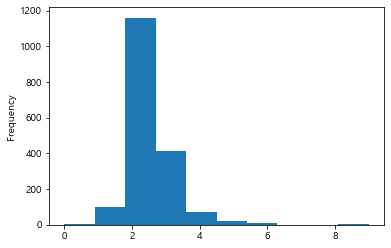

In [140]:
dfY['RAR_Q'].plot(kind='hist')

In [139]:
result.predict(dfX)

9294     2.689321
9295     2.479140
9296     1.550348
9297     2.285377
9300     1.623985
           ...   
11600    1.478192
11610    1.478192
11648    1.824268
11649    1.758226
11656    1.352379
Length: 1783, dtype: float64

In [111]:
dfY['Gap'] = dfY['RAR_Predict'] - dfY['RAR_Q']

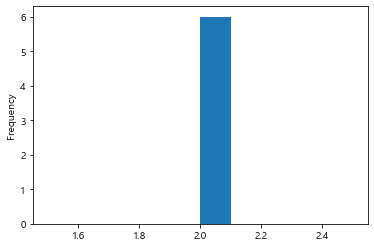

In [143]:
dfY[dfY.RAR_Predict > 4]['RAR_Q'].plot(kind='hist')

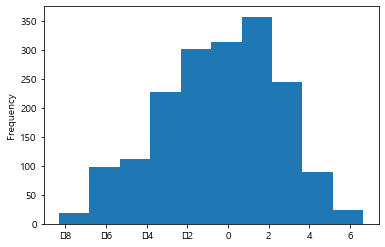

In [113]:
dfY['Gap'].plot(kind='hist')